# Solving the SWE using NN + FNO

In [2]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## Solve the SWE using NN

In [3]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape

dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])


(304, 100)

In [4]:
h_all.shape

(304, 100)

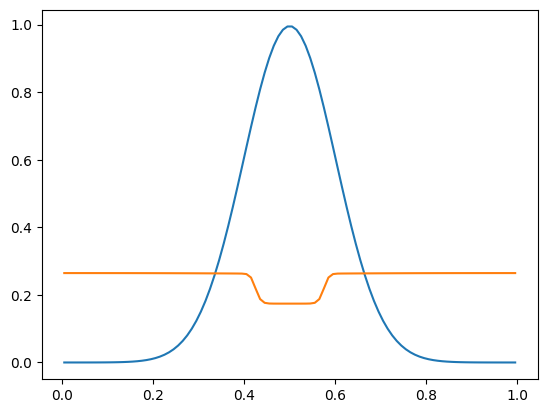

In [5]:
plt.plot(x, h_all[0])
plt.plot(x, h_all[-1])

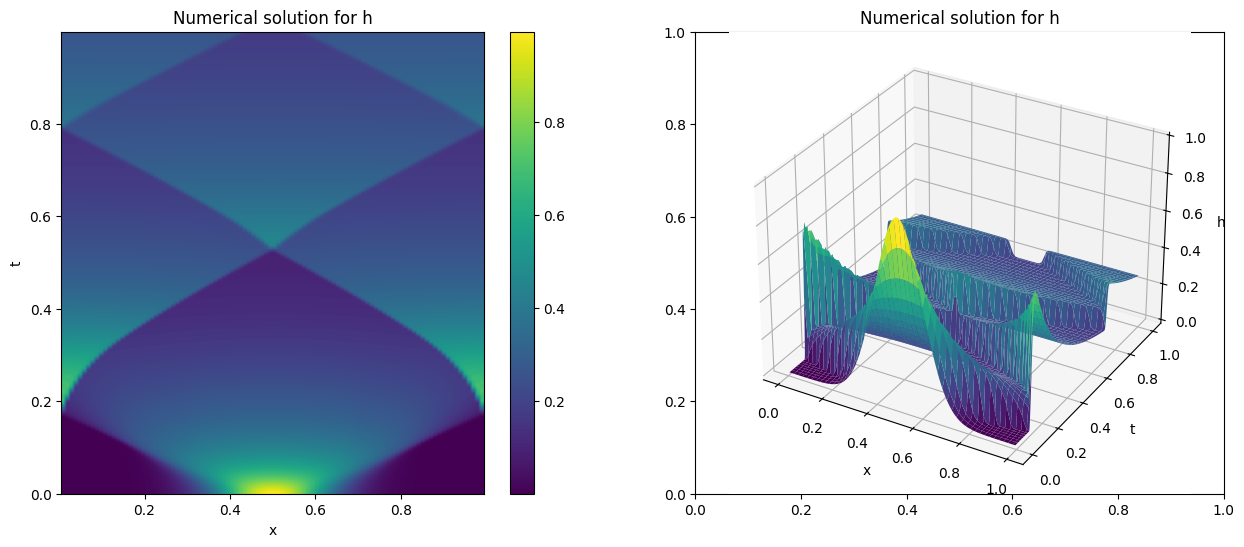

In [6]:
save = 1

# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')

if save:
    plt.savefig('plots/NN_initial.png')

plt.show()


In [7]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

### (i) FNN

c:\Users\Matteo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8515 - val_loss: 0.0607
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0621 - val_loss: 0.0539
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0465 - val_loss: 0.0290
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225 - val_loss: 0.0112
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - val_loss: 0.0074
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0201
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0051
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

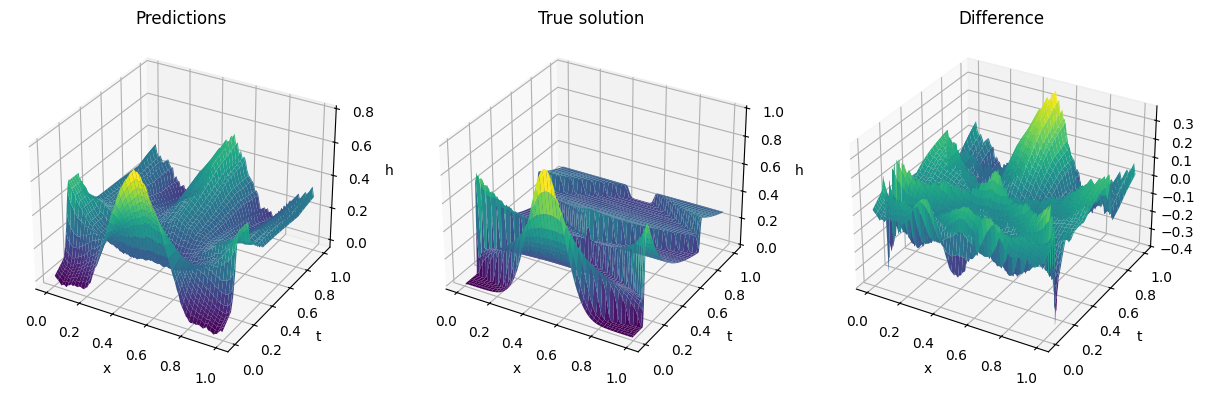

In [8]:
X, T = np.meshgrid(x, t)

# Define the NN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
model.add(BatchNormalization())  # Batch normalization layer
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer

# Compile the model
learning_rate = 0.01 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)
print(f'Test loss: {loss}')

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

if save:
    plt.savefig('plots/NN_predictions.png')

plt.show()

plt.show()


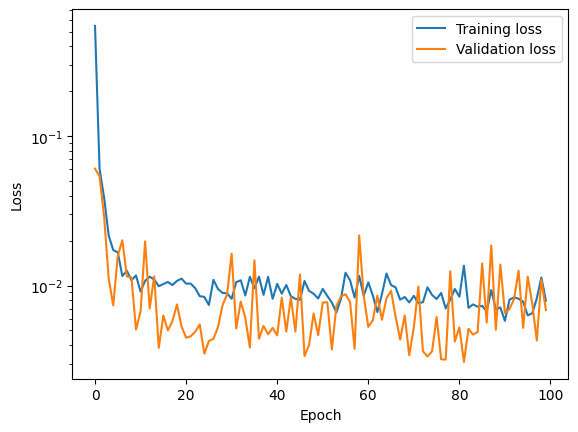

In [9]:
# Plot the training and validation loss
plt.semilogy(history.history['loss'], label='Training loss')
plt.semilogy(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

if save:
    plt.savefig('plots/NN_loss_train_val.png')

plt.show()

plt.show()

#### Calculate error in the different time steps

RMSE: 0.08348344289976069


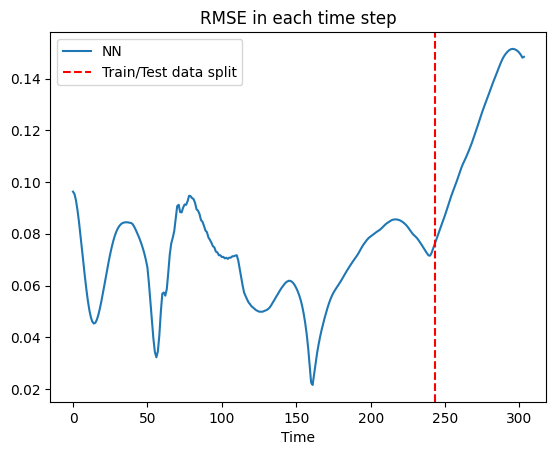

In [10]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for the predictions
rmse_val = rmse(predictions, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_NN = []

for i in range(h_all.shape[0]):
    error_NN.append(rmse(predictions[i], h_all[i]))

plt.plot(error_NN, label='NN')
plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.show()


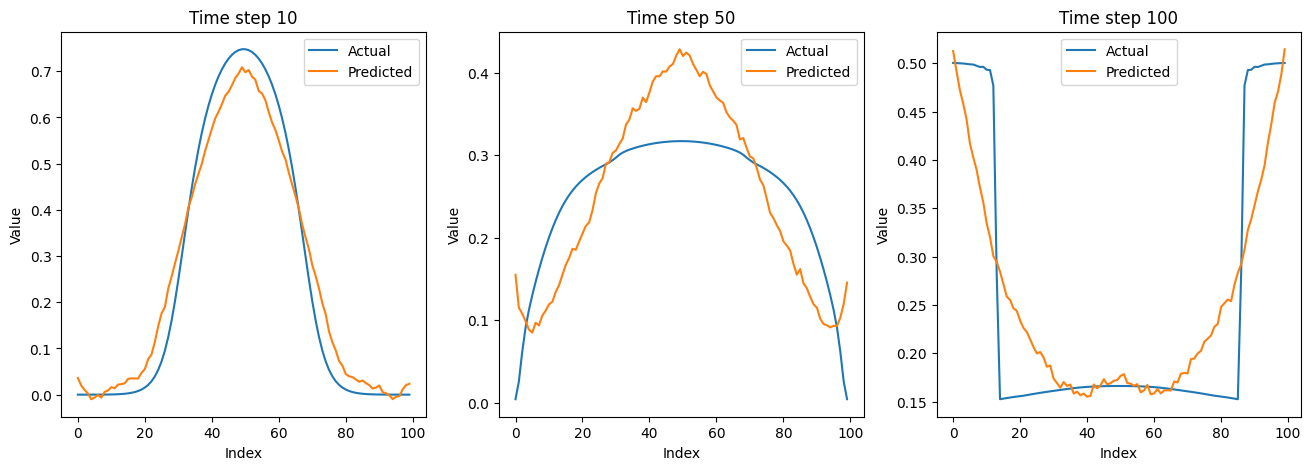

<Figure size 640x480 with 0 Axes>

In [11]:
# Define the indices for the plots
indices = [10, 50, 100]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(h_all[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

if save:
    plt.savefig('plots/NN_predictions_time_steps.png')

plt.tight_layout()
plt.show()

### (ii) LSTM

In [12]:
X, T = np.meshgrid(x, t)

# Define the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1] + T.shape[1], 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer

# Compile the model
learning_rate = 0.001 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

plt.show()

Epoch 1/100


c:\Users\Matteo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0797 - val_loss: 0.0446
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0608 - val_loss: 0.0351
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0402 - val_loss: 0.0134
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0275 - val_loss: 0.0232
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0275 - val_loss: 0.0238
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0246 - val_loss: 0.0162
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0216 - val_loss: 0.0162
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0220 - val_loss: 0.0148
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0199 - val_loss: 0.0126
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0204 - val_loss: 0.0105
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.

KeyboardInterrupt: 

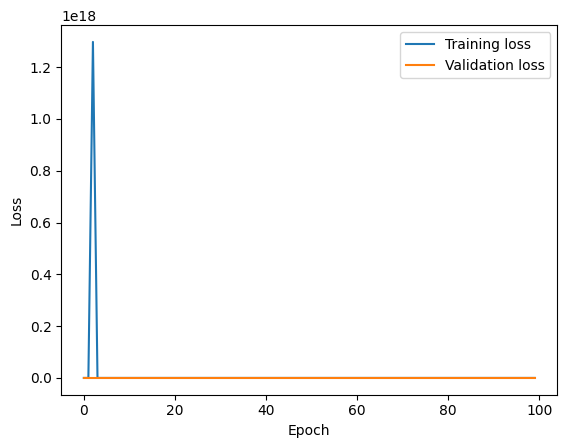

In [139]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



RMSE: 0.12286311089784206


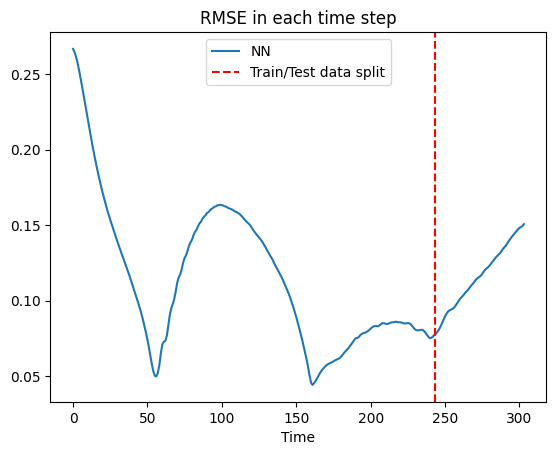

In [140]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for the predictions
rmse_val = rmse(predictions, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_NN = []

for i in range(h_all.shape[0]):
    error_NN.append(rmse(predictions[i], h_all[i]))

plt.plot(error_NN, label='NN')
plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.show()


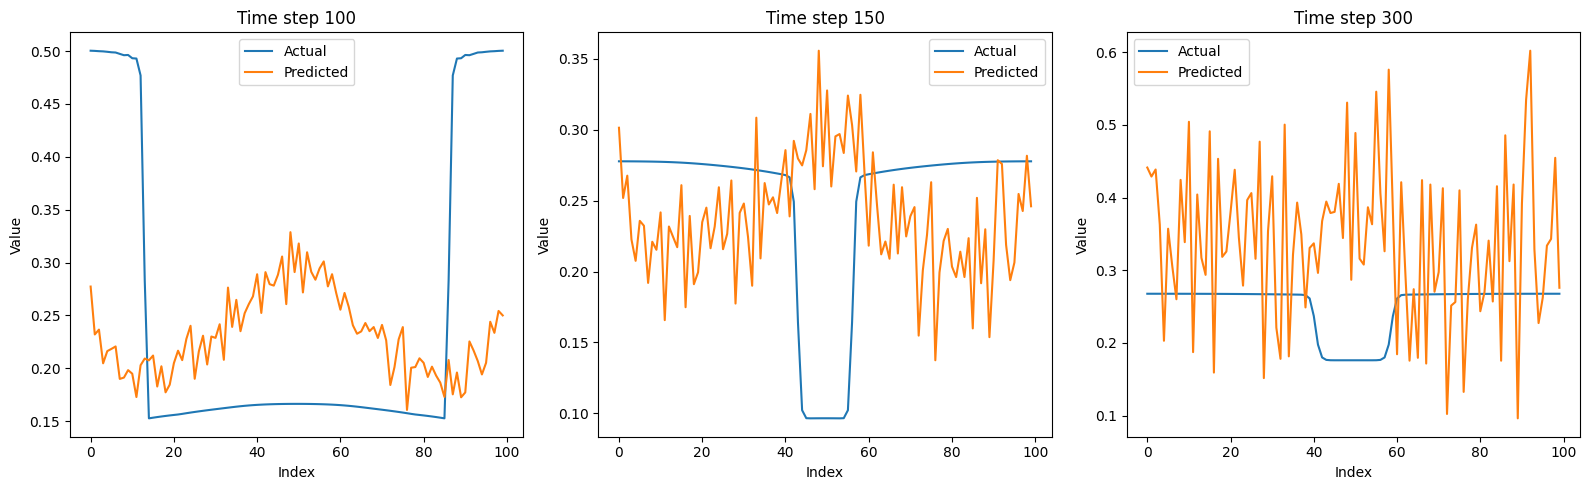

In [141]:
# Define the indices for the plots
indices = [100, 150, 300]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(h_all[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

# Save the figure
plt.tight_layout()
plt.show()

## Solve the SWE using FNO

### Define network